# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

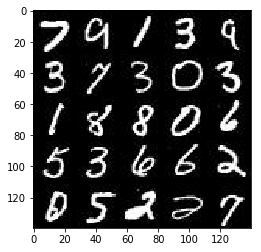

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

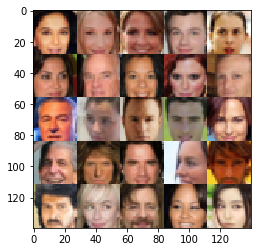

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='inputs_real')
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),name='inputs_z')
    learning_rate=tf.placeholder(tf.float32,None,name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha=0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        x1=tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1=tf.maximum(alpha*x1,x1)
        
        x2=tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2=tf.layers.batch_normalization(x2,training=True)
        relu2=tf.maximum(alpha*bn2,bn2)
        
        x3=tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        bn3=tf.layers.batch_normalization(x3,training=True)
        relu3=tf.maximum(alpha*bn3,bn3)
        
        flat=tf.reshape(relu3,(-1,4*4*256))
        logits=tf.layers.dense(flat,1)
        out=tf.sigmoid(logits)

    return out,logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator',reuse=not is_train):
        alpha=0.2
        
        x1=tf.layers.dense(z,7*7*256)
        x1=tf.reshape(x1,(-1,7,7,256))
        x1=tf.layers.batch_normalization(x1,training=is_train)
        x1=tf.maximum(alpha*x1,x1)
        
        x2=tf.layers.conv2d_transpose(x1,128,5,strides=2,padding='same')
        x2=tf.layers.batch_normalization(x2,training=is_train)
        x2=tf.maximum(alpha*x2,x2)
        
        x3=tf.layers.conv2d_transpose(x2,64,5,strides=2,padding='same')
        x3=tf.layers.batch_normalization(x3,training=is_train)
        x3=tf.maximum(alpha*x3,x3)
        
        logits=tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=1,padding='same')
        
        out=tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    size=data_shape[1]
    dim=3 if data_image_mode=='RGB' else 1
    
    input_real,input_z,var_learning_rate=model_inputs(size,size,dim,z_dim)
    
    d_loss,g_loss=model_loss(input_real,input_z,dim)
    d_opt,g_opt=model_opt(d_loss,g_loss,var_learning_rate,beta1)
    
    samples,losses=[],[]
    steps=0
    print_every=10
    show_every=100
    
    saver=tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                images=batch_images*2
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _=sess.run(d_opt,feed_dict={
                    input_real:images,
                    input_z:batch_z,
                    var_learning_rate:learning_rate
                                           })
                
                _=sess.run(g_opt,feed_dict={
                    input_z:batch_z,
                    var_learning_rate:learning_rate
                })
                
                # At the end of each epoch,get the losses and print them out
                if steps % print_every ==0:
                    train_loss_d=d_loss.eval({input_z:batch_z,input_real:images})
                    train_loss_g=g_loss.eval({input_z:batch_z})
                    
                    print('Epoch {}/{}...'.format(epoch_i+1,epoch_count),
                         'Discriminator Loss:{:.4f}...'.format(train_loss_d),
                         'Generator Loss:{:.4f}'.format(train_loss_g))
                
                if steps % show_every ==0:
                    show_generator_output(sess,25,input_z,dim,data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss:0.8783... Generator Loss:1.1130
Epoch 1/2... Discriminator Loss:0.8227... Generator Loss:1.4276
Epoch 1/2... Discriminator Loss:1.0788... Generator Loss:0.9501
Epoch 1/2... Discriminator Loss:1.6556... Generator Loss:0.3644
Epoch 1/2... Discriminator Loss:0.7817... Generator Loss:1.5891
Epoch 1/2... Discriminator Loss:0.9063... Generator Loss:1.0866
Epoch 1/2... Discriminator Loss:1.0501... Generator Loss:0.8470
Epoch 1/2... Discriminator Loss:1.1331... Generator Loss:0.7621
Epoch 1/2... Discriminator Loss:1.1352... Generator Loss:0.8541
Epoch 1/2... Discriminator Loss:1.0110... Generator Loss:1.0515


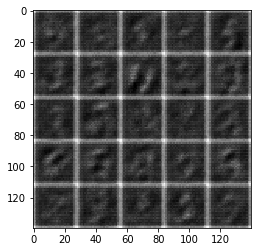

Epoch 1/2... Discriminator Loss:1.2561... Generator Loss:0.6836
Epoch 1/2... Discriminator Loss:1.0449... Generator Loss:0.9017
Epoch 1/2... Discriminator Loss:1.0138... Generator Loss:1.0065
Epoch 1/2... Discriminator Loss:1.0755... Generator Loss:0.8418
Epoch 1/2... Discriminator Loss:1.0287... Generator Loss:0.8266
Epoch 1/2... Discriminator Loss:1.0548... Generator Loss:0.9439
Epoch 1/2... Discriminator Loss:0.9138... Generator Loss:1.2407
Epoch 1/2... Discriminator Loss:1.0265... Generator Loss:1.0381
Epoch 1/2... Discriminator Loss:1.5254... Generator Loss:0.4366
Epoch 1/2... Discriminator Loss:0.9160... Generator Loss:1.1818


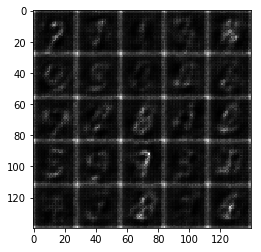

Epoch 1/2... Discriminator Loss:0.9416... Generator Loss:1.4025
Epoch 1/2... Discriminator Loss:0.8629... Generator Loss:1.2436
Epoch 1/2... Discriminator Loss:1.1461... Generator Loss:0.7123
Epoch 1/2... Discriminator Loss:0.8140... Generator Loss:1.5072
Epoch 1/2... Discriminator Loss:0.9973... Generator Loss:0.8534
Epoch 1/2... Discriminator Loss:0.9193... Generator Loss:1.3757
Epoch 1/2... Discriminator Loss:0.9678... Generator Loss:2.1111
Epoch 1/2... Discriminator Loss:1.0607... Generator Loss:2.3469
Epoch 1/2... Discriminator Loss:0.9271... Generator Loss:0.9301
Epoch 1/2... Discriminator Loss:0.7522... Generator Loss:1.8648


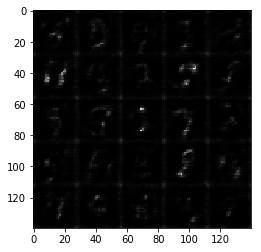

Epoch 1/2... Discriminator Loss:0.9554... Generator Loss:0.9002
Epoch 1/2... Discriminator Loss:0.9155... Generator Loss:1.9321
Epoch 1/2... Discriminator Loss:0.7761... Generator Loss:1.3640
Epoch 1/2... Discriminator Loss:0.7104... Generator Loss:1.8683
Epoch 1/2... Discriminator Loss:0.7768... Generator Loss:1.2703
Epoch 1/2... Discriminator Loss:0.8745... Generator Loss:0.9875
Epoch 1/2... Discriminator Loss:0.6750... Generator Loss:1.5526
Epoch 1/2... Discriminator Loss:0.7448... Generator Loss:1.9135
Epoch 1/2... Discriminator Loss:0.8610... Generator Loss:2.6003
Epoch 1/2... Discriminator Loss:0.9714... Generator Loss:0.8624


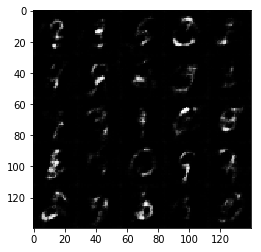

Epoch 1/2... Discriminator Loss:0.6623... Generator Loss:1.8554
Epoch 1/2... Discriminator Loss:0.7220... Generator Loss:1.8271
Epoch 1/2... Discriminator Loss:1.2413... Generator Loss:0.6316
Epoch 1/2... Discriminator Loss:0.6809... Generator Loss:1.5996
Epoch 1/2... Discriminator Loss:0.7296... Generator Loss:1.3785
Epoch 1/2... Discriminator Loss:0.6849... Generator Loss:1.5050
Epoch 1/2... Discriminator Loss:0.7366... Generator Loss:2.4338
Epoch 1/2... Discriminator Loss:0.6712... Generator Loss:2.1455
Epoch 1/2... Discriminator Loss:0.6645... Generator Loss:1.5912
Epoch 1/2... Discriminator Loss:0.6815... Generator Loss:1.6280


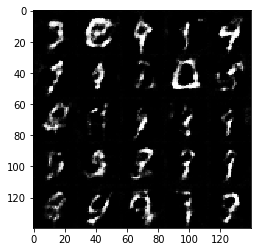

Epoch 1/2... Discriminator Loss:0.6911... Generator Loss:2.0545
Epoch 1/2... Discriminator Loss:0.6553... Generator Loss:1.8598
Epoch 1/2... Discriminator Loss:0.6829... Generator Loss:1.5365
Epoch 1/2... Discriminator Loss:0.7787... Generator Loss:1.3311
Epoch 1/2... Discriminator Loss:0.8432... Generator Loss:1.4195
Epoch 1/2... Discriminator Loss:0.7993... Generator Loss:1.4216
Epoch 1/2... Discriminator Loss:1.1283... Generator Loss:3.2243
Epoch 1/2... Discriminator Loss:0.7291... Generator Loss:1.4344
Epoch 1/2... Discriminator Loss:0.7952... Generator Loss:1.3491
Epoch 1/2... Discriminator Loss:1.1152... Generator Loss:0.7529


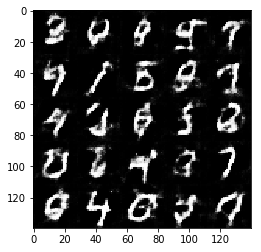

Epoch 1/2... Discriminator Loss:0.9470... Generator Loss:2.0298
Epoch 1/2... Discriminator Loss:0.7691... Generator Loss:1.5174
Epoch 1/2... Discriminator Loss:0.9498... Generator Loss:0.9308
Epoch 1/2... Discriminator Loss:1.1070... Generator Loss:0.8066
Epoch 1/2... Discriminator Loss:0.9674... Generator Loss:1.9207
Epoch 1/2... Discriminator Loss:1.0055... Generator Loss:1.0553
Epoch 1/2... Discriminator Loss:1.0173... Generator Loss:0.9191
Epoch 1/2... Discriminator Loss:0.8491... Generator Loss:1.1232
Epoch 1/2... Discriminator Loss:0.8572... Generator Loss:1.3377
Epoch 1/2... Discriminator Loss:1.2353... Generator Loss:2.5404


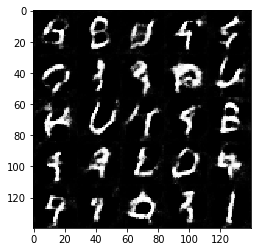

Epoch 1/2... Discriminator Loss:1.0713... Generator Loss:0.7858
Epoch 1/2... Discriminator Loss:0.8938... Generator Loss:1.8835
Epoch 1/2... Discriminator Loss:0.8064... Generator Loss:1.3696
Epoch 1/2... Discriminator Loss:1.0637... Generator Loss:0.8412
Epoch 1/2... Discriminator Loss:0.8299... Generator Loss:1.5851
Epoch 1/2... Discriminator Loss:1.0908... Generator Loss:1.9522
Epoch 1/2... Discriminator Loss:0.9276... Generator Loss:1.3560
Epoch 1/2... Discriminator Loss:0.7870... Generator Loss:1.4524
Epoch 1/2... Discriminator Loss:1.0133... Generator Loss:0.8811
Epoch 1/2... Discriminator Loss:0.8960... Generator Loss:1.3970


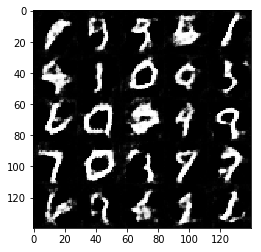

Epoch 1/2... Discriminator Loss:0.8820... Generator Loss:2.0597
Epoch 1/2... Discriminator Loss:0.8232... Generator Loss:1.5916
Epoch 1/2... Discriminator Loss:0.8732... Generator Loss:1.3135
Epoch 1/2... Discriminator Loss:0.8849... Generator Loss:1.2033
Epoch 1/2... Discriminator Loss:0.8803... Generator Loss:1.5923
Epoch 1/2... Discriminator Loss:0.8463... Generator Loss:1.7342
Epoch 1/2... Discriminator Loss:0.9816... Generator Loss:0.9299
Epoch 1/2... Discriminator Loss:0.9038... Generator Loss:1.7781
Epoch 1/2... Discriminator Loss:0.8204... Generator Loss:1.4289
Epoch 1/2... Discriminator Loss:0.8891... Generator Loss:1.5610


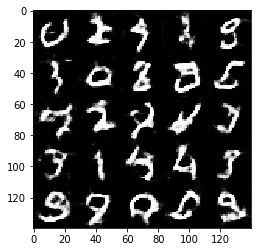

Epoch 1/2... Discriminator Loss:1.2794... Generator Loss:2.4172
Epoch 1/2... Discriminator Loss:0.9013... Generator Loss:1.7188
Epoch 1/2... Discriminator Loss:0.8690... Generator Loss:1.0874
Epoch 2/2... Discriminator Loss:0.8112... Generator Loss:1.1988
Epoch 2/2... Discriminator Loss:0.9263... Generator Loss:1.0112
Epoch 2/2... Discriminator Loss:0.8120... Generator Loss:1.4380
Epoch 2/2... Discriminator Loss:0.7900... Generator Loss:1.3779
Epoch 2/2... Discriminator Loss:0.7859... Generator Loss:1.6540
Epoch 2/2... Discriminator Loss:0.9446... Generator Loss:1.1022
Epoch 2/2... Discriminator Loss:1.1186... Generator Loss:0.7773


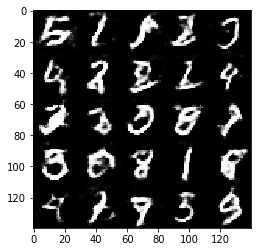

Epoch 2/2... Discriminator Loss:0.8551... Generator Loss:1.8592
Epoch 2/2... Discriminator Loss:0.8987... Generator Loss:1.2094
Epoch 2/2... Discriminator Loss:1.0430... Generator Loss:0.8410
Epoch 2/2... Discriminator Loss:0.8910... Generator Loss:1.1100
Epoch 2/2... Discriminator Loss:0.9335... Generator Loss:1.3251
Epoch 2/2... Discriminator Loss:0.8064... Generator Loss:1.5898
Epoch 2/2... Discriminator Loss:0.9393... Generator Loss:1.0231
Epoch 2/2... Discriminator Loss:0.8195... Generator Loss:1.3872
Epoch 2/2... Discriminator Loss:0.8797... Generator Loss:1.1263
Epoch 2/2... Discriminator Loss:0.9726... Generator Loss:0.9371


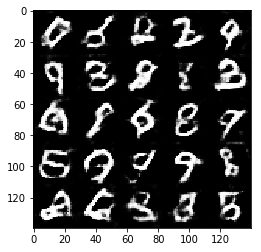

Epoch 2/2... Discriminator Loss:0.8382... Generator Loss:1.2005
Epoch 2/2... Discriminator Loss:0.8892... Generator Loss:1.3187
Epoch 2/2... Discriminator Loss:0.9780... Generator Loss:1.4576
Epoch 2/2... Discriminator Loss:0.8104... Generator Loss:1.3239
Epoch 2/2... Discriminator Loss:0.8518... Generator Loss:1.1816
Epoch 2/2... Discriminator Loss:0.8604... Generator Loss:2.0071
Epoch 2/2... Discriminator Loss:0.8452... Generator Loss:1.5290
Epoch 2/2... Discriminator Loss:1.0300... Generator Loss:2.0350
Epoch 2/2... Discriminator Loss:0.9412... Generator Loss:0.9914
Epoch 2/2... Discriminator Loss:0.8442... Generator Loss:1.3688


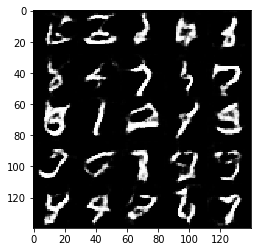

Epoch 2/2... Discriminator Loss:0.9051... Generator Loss:1.9579
Epoch 2/2... Discriminator Loss:0.9717... Generator Loss:0.9016
Epoch 2/2... Discriminator Loss:0.9558... Generator Loss:0.9819
Epoch 2/2... Discriminator Loss:0.8719... Generator Loss:1.0303
Epoch 2/2... Discriminator Loss:0.8621... Generator Loss:1.2547
Epoch 2/2... Discriminator Loss:0.7773... Generator Loss:1.3944
Epoch 2/2... Discriminator Loss:0.8182... Generator Loss:1.1463
Epoch 2/2... Discriminator Loss:0.9980... Generator Loss:2.2422
Epoch 2/2... Discriminator Loss:1.0498... Generator Loss:0.8066
Epoch 2/2... Discriminator Loss:1.0894... Generator Loss:0.7793


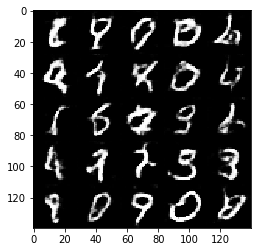

Epoch 2/2... Discriminator Loss:0.8143... Generator Loss:1.3839
Epoch 2/2... Discriminator Loss:0.7714... Generator Loss:1.4544
Epoch 2/2... Discriminator Loss:0.8499... Generator Loss:1.5965
Epoch 2/2... Discriminator Loss:0.8307... Generator Loss:1.9836
Epoch 2/2... Discriminator Loss:0.8120... Generator Loss:1.6509
Epoch 2/2... Discriminator Loss:0.8902... Generator Loss:1.0766
Epoch 2/2... Discriminator Loss:0.7394... Generator Loss:1.7130
Epoch 2/2... Discriminator Loss:0.7327... Generator Loss:1.6272
Epoch 2/2... Discriminator Loss:0.6848... Generator Loss:1.6274
Epoch 2/2... Discriminator Loss:0.8160... Generator Loss:1.2945


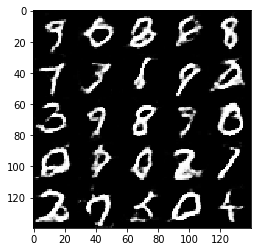

Epoch 2/2... Discriminator Loss:0.7265... Generator Loss:1.9746
Epoch 2/2... Discriminator Loss:0.7600... Generator Loss:1.8144
Epoch 2/2... Discriminator Loss:0.7138... Generator Loss:1.5438
Epoch 2/2... Discriminator Loss:0.9755... Generator Loss:0.8894
Epoch 2/2... Discriminator Loss:1.0214... Generator Loss:0.8868
Epoch 2/2... Discriminator Loss:0.7608... Generator Loss:1.3280
Epoch 2/2... Discriminator Loss:0.8505... Generator Loss:1.0604
Epoch 2/2... Discriminator Loss:0.7775... Generator Loss:1.4662
Epoch 2/2... Discriminator Loss:0.8655... Generator Loss:1.2046
Epoch 2/2... Discriminator Loss:0.7613... Generator Loss:1.3691


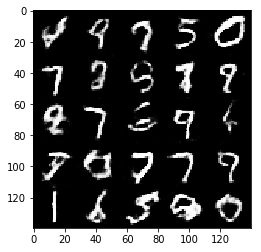

Epoch 2/2... Discriminator Loss:0.8000... Generator Loss:1.2567
Epoch 2/2... Discriminator Loss:0.7499... Generator Loss:1.3206
Epoch 2/2... Discriminator Loss:0.8472... Generator Loss:2.1078
Epoch 2/2... Discriminator Loss:0.7118... Generator Loss:1.3852
Epoch 2/2... Discriminator Loss:0.7405... Generator Loss:1.4143
Epoch 2/2... Discriminator Loss:0.7888... Generator Loss:1.2138
Epoch 2/2... Discriminator Loss:0.7506... Generator Loss:1.6405
Epoch 2/2... Discriminator Loss:0.7324... Generator Loss:1.4317
Epoch 2/2... Discriminator Loss:0.6697... Generator Loss:1.5838
Epoch 2/2... Discriminator Loss:1.0950... Generator Loss:0.8054


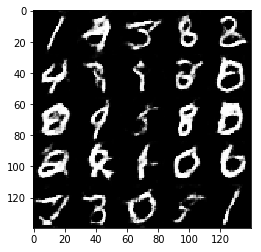

Epoch 2/2... Discriminator Loss:0.7775... Generator Loss:1.4660
Epoch 2/2... Discriminator Loss:0.9158... Generator Loss:0.9729
Epoch 2/2... Discriminator Loss:0.8000... Generator Loss:1.1964
Epoch 2/2... Discriminator Loss:0.7581... Generator Loss:1.5064
Epoch 2/2... Discriminator Loss:0.9511... Generator Loss:0.9349
Epoch 2/2... Discriminator Loss:0.7658... Generator Loss:1.8810
Epoch 2/2... Discriminator Loss:0.8094... Generator Loss:1.1352
Epoch 2/2... Discriminator Loss:0.7594... Generator Loss:2.0617
Epoch 2/2... Discriminator Loss:0.7224... Generator Loss:1.5410
Epoch 2/2... Discriminator Loss:0.6681... Generator Loss:1.5045


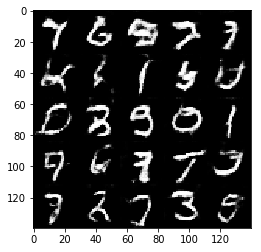

Epoch 2/2... Discriminator Loss:0.7801... Generator Loss:2.0524
Epoch 2/2... Discriminator Loss:0.7173... Generator Loss:1.5314
Epoch 2/2... Discriminator Loss:0.6558... Generator Loss:1.6392
Epoch 2/2... Discriminator Loss:0.9190... Generator Loss:1.0064
Epoch 2/2... Discriminator Loss:1.6709... Generator Loss:0.4303
Epoch 2/2... Discriminator Loss:0.7849... Generator Loss:1.4883
Epoch 2/2... Discriminator Loss:0.6881... Generator Loss:1.6968
Epoch 2/2... Discriminator Loss:0.8634... Generator Loss:1.1413
Epoch 2/2... Discriminator Loss:0.8144... Generator Loss:1.3111
Epoch 2/2... Discriminator Loss:0.7221... Generator Loss:1.6268


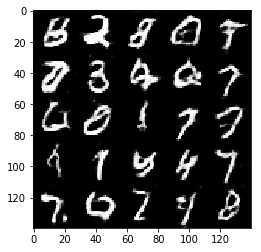

Epoch 2/2... Discriminator Loss:0.6562... Generator Loss:1.7532
Epoch 2/2... Discriminator Loss:0.8889... Generator Loss:1.0701
Epoch 2/2... Discriminator Loss:0.9780... Generator Loss:0.9119
Epoch 2/2... Discriminator Loss:1.0304... Generator Loss:0.8318
Epoch 2/2... Discriminator Loss:0.9237... Generator Loss:2.5704
Epoch 2/2... Discriminator Loss:0.7377... Generator Loss:1.3232
Epoch 2/2... Discriminator Loss:0.7426... Generator Loss:1.5701


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss:0.7103... Generator Loss:27.3127
Epoch 1/1... Discriminator Loss:0.7912... Generator Loss:2.7465
Epoch 1/1... Discriminator Loss:0.6279... Generator Loss:3.3352
Epoch 1/1... Discriminator Loss:0.8186... Generator Loss:2.9904
Epoch 1/1... Discriminator Loss:0.6484... Generator Loss:2.8216
Epoch 1/1... Discriminator Loss:0.6671... Generator Loss:2.3515
Epoch 1/1... Discriminator Loss:0.5360... Generator Loss:3.5835
Epoch 1/1... Discriminator Loss:0.8101... Generator Loss:1.3701
Epoch 1/1... Discriminator Loss:0.4954... Generator Loss:3.4872
Epoch 1/1... Discriminator Loss:0.5793... Generator Loss:3.6903


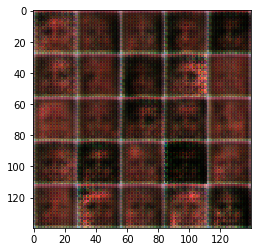

Epoch 1/1... Discriminator Loss:1.0703... Generator Loss:2.0099
Epoch 1/1... Discriminator Loss:1.8153... Generator Loss:3.7882
Epoch 1/1... Discriminator Loss:1.0515... Generator Loss:1.1161
Epoch 1/1... Discriminator Loss:1.1585... Generator Loss:1.5368
Epoch 1/1... Discriminator Loss:1.3233... Generator Loss:2.5681
Epoch 1/1... Discriminator Loss:1.1878... Generator Loss:0.9128
Epoch 1/1... Discriminator Loss:1.5770... Generator Loss:2.1483
Epoch 1/1... Discriminator Loss:1.0369... Generator Loss:1.2543
Epoch 1/1... Discriminator Loss:2.3079... Generator Loss:2.4568
Epoch 1/1... Discriminator Loss:2.0855... Generator Loss:0.9998


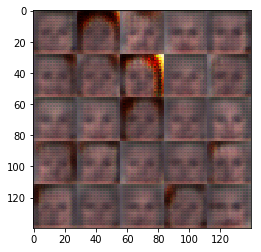

Epoch 1/1... Discriminator Loss:1.7745... Generator Loss:0.3648
Epoch 1/1... Discriminator Loss:1.3224... Generator Loss:1.3276
Epoch 1/1... Discriminator Loss:1.1602... Generator Loss:0.8170
Epoch 1/1... Discriminator Loss:1.4680... Generator Loss:0.4450
Epoch 1/1... Discriminator Loss:0.9521... Generator Loss:1.4793
Epoch 1/1... Discriminator Loss:0.9975... Generator Loss:1.4483
Epoch 1/1... Discriminator Loss:0.9569... Generator Loss:1.1057
Epoch 1/1... Discriminator Loss:3.7685... Generator Loss:4.2111
Epoch 1/1... Discriminator Loss:1.2425... Generator Loss:0.9368
Epoch 1/1... Discriminator Loss:1.3278... Generator Loss:0.9185


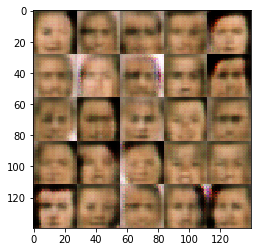

Epoch 1/1... Discriminator Loss:1.2686... Generator Loss:0.9337
Epoch 1/1... Discriminator Loss:1.3177... Generator Loss:0.8792
Epoch 1/1... Discriminator Loss:1.3100... Generator Loss:0.8683
Epoch 1/1... Discriminator Loss:1.3897... Generator Loss:0.7426
Epoch 1/1... Discriminator Loss:1.2577... Generator Loss:0.7910
Epoch 1/1... Discriminator Loss:1.3265... Generator Loss:0.7272
Epoch 1/1... Discriminator Loss:1.3341... Generator Loss:0.7540
Epoch 1/1... Discriminator Loss:1.3439... Generator Loss:1.1022
Epoch 1/1... Discriminator Loss:1.2647... Generator Loss:0.6430
Epoch 1/1... Discriminator Loss:1.7954... Generator Loss:2.1230


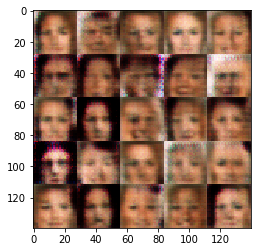

Epoch 1/1... Discriminator Loss:1.3507... Generator Loss:0.5320
Epoch 1/1... Discriminator Loss:1.0326... Generator Loss:1.4295
Epoch 1/1... Discriminator Loss:1.0287... Generator Loss:0.9517
Epoch 1/1... Discriminator Loss:1.4209... Generator Loss:1.3230
Epoch 1/1... Discriminator Loss:1.6756... Generator Loss:0.3863
Epoch 1/1... Discriminator Loss:1.2662... Generator Loss:1.2103
Epoch 1/1... Discriminator Loss:0.9263... Generator Loss:1.5981
Epoch 1/1... Discriminator Loss:1.2950... Generator Loss:0.8965
Epoch 1/1... Discriminator Loss:1.3856... Generator Loss:0.8734
Epoch 1/1... Discriminator Loss:1.3051... Generator Loss:0.9249


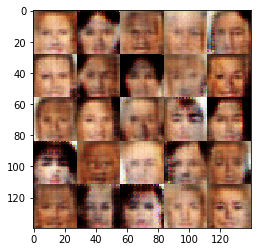

Epoch 1/1... Discriminator Loss:1.3470... Generator Loss:0.8406
Epoch 1/1... Discriminator Loss:1.7128... Generator Loss:2.4280
Epoch 1/1... Discriminator Loss:1.6766... Generator Loss:0.3579
Epoch 1/1... Discriminator Loss:1.4786... Generator Loss:0.8697
Epoch 1/1... Discriminator Loss:0.9437... Generator Loss:1.3152
Epoch 1/1... Discriminator Loss:0.9444... Generator Loss:2.5225
Epoch 1/1... Discriminator Loss:1.2576... Generator Loss:1.3286
Epoch 1/1... Discriminator Loss:1.2394... Generator Loss:0.8709
Epoch 1/1... Discriminator Loss:1.1119... Generator Loss:1.4135
Epoch 1/1... Discriminator Loss:1.4403... Generator Loss:1.6745


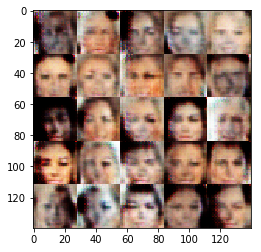

Epoch 1/1... Discriminator Loss:1.2703... Generator Loss:1.0150
Epoch 1/1... Discriminator Loss:1.3375... Generator Loss:0.6486
Epoch 1/1... Discriminator Loss:2.8507... Generator Loss:0.1043
Epoch 1/1... Discriminator Loss:1.5695... Generator Loss:0.6924
Epoch 1/1... Discriminator Loss:1.2494... Generator Loss:0.8790
Epoch 1/1... Discriminator Loss:1.5177... Generator Loss:0.6864
Epoch 1/1... Discriminator Loss:1.1309... Generator Loss:0.8041
Epoch 1/1... Discriminator Loss:1.2797... Generator Loss:1.5023
Epoch 1/1... Discriminator Loss:1.2873... Generator Loss:1.1940
Epoch 1/1... Discriminator Loss:1.2806... Generator Loss:0.6687


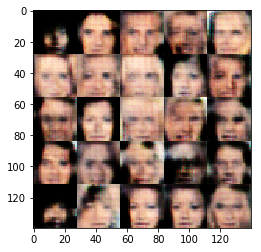

Epoch 1/1... Discriminator Loss:1.4827... Generator Loss:0.5973
Epoch 1/1... Discriminator Loss:1.4653... Generator Loss:0.6369
Epoch 1/1... Discriminator Loss:1.3682... Generator Loss:1.9815
Epoch 1/1... Discriminator Loss:1.3081... Generator Loss:0.9402
Epoch 1/1... Discriminator Loss:1.3265... Generator Loss:0.8470
Epoch 1/1... Discriminator Loss:1.3915... Generator Loss:0.5969
Epoch 1/1... Discriminator Loss:1.2540... Generator Loss:0.8324
Epoch 1/1... Discriminator Loss:1.2396... Generator Loss:0.8685
Epoch 1/1... Discriminator Loss:0.9677... Generator Loss:0.9971
Epoch 1/1... Discriminator Loss:1.2641... Generator Loss:1.0437


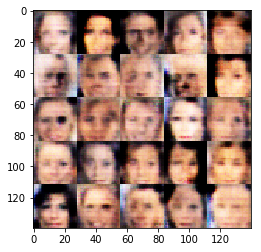

Epoch 1/1... Discriminator Loss:1.5369... Generator Loss:0.6348
Epoch 1/1... Discriminator Loss:1.3488... Generator Loss:0.8728
Epoch 1/1... Discriminator Loss:1.3517... Generator Loss:0.7899
Epoch 1/1... Discriminator Loss:1.3900... Generator Loss:0.9316
Epoch 1/1... Discriminator Loss:1.2671... Generator Loss:1.0705
Epoch 1/1... Discriminator Loss:1.3100... Generator Loss:0.5662
Epoch 1/1... Discriminator Loss:1.5815... Generator Loss:1.8639
Epoch 1/1... Discriminator Loss:1.6317... Generator Loss:1.2818
Epoch 1/1... Discriminator Loss:1.1456... Generator Loss:0.7086
Epoch 1/1... Discriminator Loss:1.5996... Generator Loss:0.9693


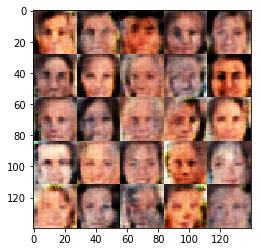

Epoch 1/1... Discriminator Loss:1.3637... Generator Loss:0.9641
Epoch 1/1... Discriminator Loss:1.3299... Generator Loss:0.8772
Epoch 1/1... Discriminator Loss:1.7508... Generator Loss:0.5498
Epoch 1/1... Discriminator Loss:1.6581... Generator Loss:0.6756
Epoch 1/1... Discriminator Loss:1.2447... Generator Loss:0.9398
Epoch 1/1... Discriminator Loss:1.3995... Generator Loss:0.8108
Epoch 1/1... Discriminator Loss:1.3969... Generator Loss:1.0186
Epoch 1/1... Discriminator Loss:1.2067... Generator Loss:0.8649
Epoch 1/1... Discriminator Loss:1.2218... Generator Loss:0.9337
Epoch 1/1... Discriminator Loss:1.3904... Generator Loss:1.0835


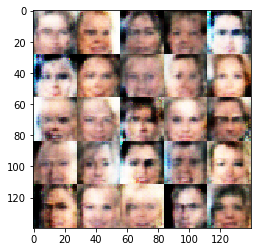

Epoch 1/1... Discriminator Loss:1.4207... Generator Loss:0.7377
Epoch 1/1... Discriminator Loss:1.4065... Generator Loss:0.7457
Epoch 1/1... Discriminator Loss:1.3451... Generator Loss:0.7741
Epoch 1/1... Discriminator Loss:1.4617... Generator Loss:0.6860
Epoch 1/1... Discriminator Loss:1.2849... Generator Loss:0.9085
Epoch 1/1... Discriminator Loss:1.5634... Generator Loss:0.8392
Epoch 1/1... Discriminator Loss:1.3307... Generator Loss:0.7845
Epoch 1/1... Discriminator Loss:1.5172... Generator Loss:0.5470
Epoch 1/1... Discriminator Loss:1.3713... Generator Loss:0.5664
Epoch 1/1... Discriminator Loss:1.3980... Generator Loss:0.8293


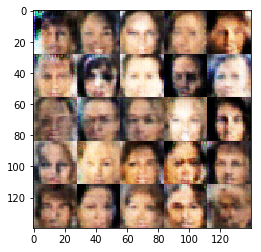

Epoch 1/1... Discriminator Loss:1.5183... Generator Loss:0.5594
Epoch 1/1... Discriminator Loss:1.4934... Generator Loss:1.5081
Epoch 1/1... Discriminator Loss:1.2708... Generator Loss:1.0006
Epoch 1/1... Discriminator Loss:1.4797... Generator Loss:1.1230
Epoch 1/1... Discriminator Loss:1.3683... Generator Loss:0.8192
Epoch 1/1... Discriminator Loss:1.2401... Generator Loss:0.7516
Epoch 1/1... Discriminator Loss:1.3458... Generator Loss:0.8164
Epoch 1/1... Discriminator Loss:1.3334... Generator Loss:0.6606
Epoch 1/1... Discriminator Loss:1.2191... Generator Loss:0.9361
Epoch 1/1... Discriminator Loss:1.3502... Generator Loss:0.7695


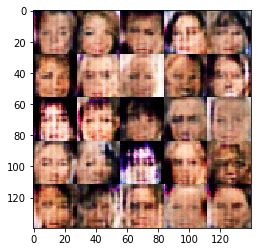

Epoch 1/1... Discriminator Loss:1.4941... Generator Loss:0.8099
Epoch 1/1... Discriminator Loss:1.3262... Generator Loss:0.9356
Epoch 1/1... Discriminator Loss:2.4546... Generator Loss:2.8575
Epoch 1/1... Discriminator Loss:1.3123... Generator Loss:0.8952
Epoch 1/1... Discriminator Loss:1.4217... Generator Loss:0.8543
Epoch 1/1... Discriminator Loss:1.3462... Generator Loss:0.6742
Epoch 1/1... Discriminator Loss:1.2395... Generator Loss:0.7443
Epoch 1/1... Discriminator Loss:1.2766... Generator Loss:0.9919
Epoch 1/1... Discriminator Loss:1.2827... Generator Loss:0.8353
Epoch 1/1... Discriminator Loss:1.2752... Generator Loss:0.7919


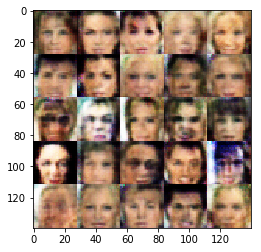

Epoch 1/1... Discriminator Loss:1.3799... Generator Loss:0.5622
Epoch 1/1... Discriminator Loss:1.2610... Generator Loss:0.6766
Epoch 1/1... Discriminator Loss:1.3653... Generator Loss:0.7056
Epoch 1/1... Discriminator Loss:1.2891... Generator Loss:0.7977
Epoch 1/1... Discriminator Loss:1.3605... Generator Loss:0.7214
Epoch 1/1... Discriminator Loss:1.5520... Generator Loss:0.7135
Epoch 1/1... Discriminator Loss:1.7765... Generator Loss:1.5885
Epoch 1/1... Discriminator Loss:1.3242... Generator Loss:1.0894
Epoch 1/1... Discriminator Loss:1.4200... Generator Loss:0.6683
Epoch 1/1... Discriminator Loss:1.0162... Generator Loss:0.9526


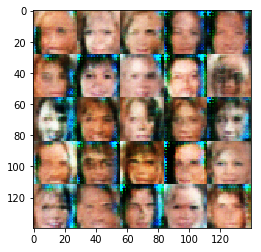

Epoch 1/1... Discriminator Loss:1.1806... Generator Loss:0.9191
Epoch 1/1... Discriminator Loss:1.3938... Generator Loss:0.7463
Epoch 1/1... Discriminator Loss:1.0432... Generator Loss:1.3590
Epoch 1/1... Discriminator Loss:1.3303... Generator Loss:0.6176
Epoch 1/1... Discriminator Loss:1.2219... Generator Loss:1.1413
Epoch 1/1... Discriminator Loss:1.1915... Generator Loss:0.7650
Epoch 1/1... Discriminator Loss:1.2677... Generator Loss:0.7939
Epoch 1/1... Discriminator Loss:1.5062... Generator Loss:0.8612
Epoch 1/1... Discriminator Loss:1.3272... Generator Loss:0.7724


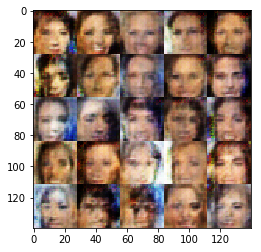

Epoch 1/1... Discriminator Loss:1.3575... Generator Loss:0.8071
Epoch 1/1... Discriminator Loss:1.3811... Generator Loss:0.7629
Epoch 1/1... Discriminator Loss:1.3811... Generator Loss:0.8227
Epoch 1/1... Discriminator Loss:1.1694... Generator Loss:0.9252
Epoch 1/1... Discriminator Loss:1.5036... Generator Loss:0.6992
Epoch 1/1... Discriminator Loss:1.3527... Generator Loss:0.7385
Epoch 1/1... Discriminator Loss:1.3237... Generator Loss:0.8754
Epoch 1/1... Discriminator Loss:1.2108... Generator Loss:0.8871
Epoch 1/1... Discriminator Loss:1.3263... Generator Loss:0.9373
Epoch 1/1... Discriminator Loss:1.3518... Generator Loss:0.7346


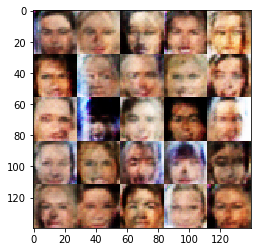

Epoch 1/1... Discriminator Loss:1.1534... Generator Loss:0.9281
Epoch 1/1... Discriminator Loss:1.2750... Generator Loss:0.9747
Epoch 1/1... Discriminator Loss:1.2407... Generator Loss:0.8204
Epoch 1/1... Discriminator Loss:1.3462... Generator Loss:0.6854
Epoch 1/1... Discriminator Loss:1.2300... Generator Loss:1.1228
Epoch 1/1... Discriminator Loss:1.5635... Generator Loss:0.4874
Epoch 1/1... Discriminator Loss:1.3815... Generator Loss:0.8416
Epoch 1/1... Discriminator Loss:1.2561... Generator Loss:0.8350
Epoch 1/1... Discriminator Loss:1.4594... Generator Loss:0.8825
Epoch 1/1... Discriminator Loss:1.2725... Generator Loss:0.8211


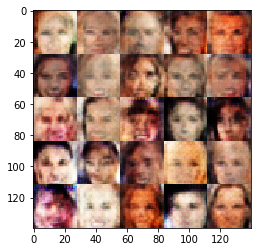

Epoch 1/1... Discriminator Loss:1.3385... Generator Loss:0.7257
Epoch 1/1... Discriminator Loss:1.3247... Generator Loss:1.0929
Epoch 1/1... Discriminator Loss:1.2851... Generator Loss:0.8245
Epoch 1/1... Discriminator Loss:1.2227... Generator Loss:0.9479
Epoch 1/1... Discriminator Loss:1.6342... Generator Loss:0.4780
Epoch 1/1... Discriminator Loss:1.3466... Generator Loss:0.8470
Epoch 1/1... Discriminator Loss:1.4692... Generator Loss:0.9632
Epoch 1/1... Discriminator Loss:1.1724... Generator Loss:0.8725
Epoch 1/1... Discriminator Loss:1.3930... Generator Loss:0.8553
Epoch 1/1... Discriminator Loss:1.1860... Generator Loss:0.9179


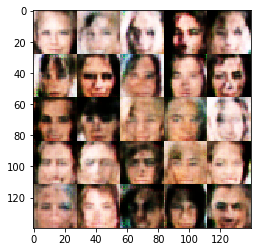

Epoch 1/1... Discriminator Loss:1.2942... Generator Loss:0.8385
Epoch 1/1... Discriminator Loss:1.3068... Generator Loss:1.0410
Epoch 1/1... Discriminator Loss:1.3343... Generator Loss:1.0033
Epoch 1/1... Discriminator Loss:1.4241... Generator Loss:1.0456
Epoch 1/1... Discriminator Loss:1.3111... Generator Loss:0.9632
Epoch 1/1... Discriminator Loss:1.6469... Generator Loss:0.4509
Epoch 1/1... Discriminator Loss:1.4067... Generator Loss:0.6160
Epoch 1/1... Discriminator Loss:1.4163... Generator Loss:0.7873
Epoch 1/1... Discriminator Loss:1.4249... Generator Loss:1.0617
Epoch 1/1... Discriminator Loss:1.2100... Generator Loss:0.8804


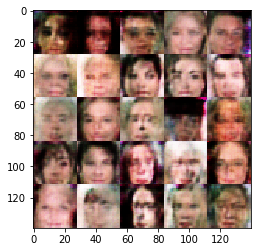

Epoch 1/1... Discriminator Loss:1.9122... Generator Loss:1.8236
Epoch 1/1... Discriminator Loss:1.4988... Generator Loss:0.8511
Epoch 1/1... Discriminator Loss:1.3482... Generator Loss:0.7579
Epoch 1/1... Discriminator Loss:1.0994... Generator Loss:1.3439
Epoch 1/1... Discriminator Loss:1.3205... Generator Loss:1.2431
Epoch 1/1... Discriminator Loss:1.1715... Generator Loss:0.9979
Epoch 1/1... Discriminator Loss:1.3574... Generator Loss:0.7572
Epoch 1/1... Discriminator Loss:1.4457... Generator Loss:1.0428
Epoch 1/1... Discriminator Loss:1.3959... Generator Loss:0.8329
Epoch 1/1... Discriminator Loss:1.4740... Generator Loss:0.7231


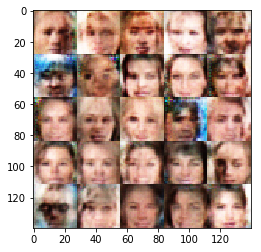

Epoch 1/1... Discriminator Loss:1.3289... Generator Loss:0.8406
Epoch 1/1... Discriminator Loss:1.3136... Generator Loss:0.7871
Epoch 1/1... Discriminator Loss:1.4177... Generator Loss:0.9196
Epoch 1/1... Discriminator Loss:1.3208... Generator Loss:0.9206
Epoch 1/1... Discriminator Loss:1.5327... Generator Loss:0.4285
Epoch 1/1... Discriminator Loss:1.2948... Generator Loss:0.9528
Epoch 1/1... Discriminator Loss:1.2849... Generator Loss:0.8495
Epoch 1/1... Discriminator Loss:1.1387... Generator Loss:0.9577
Epoch 1/1... Discriminator Loss:1.4074... Generator Loss:1.1766
Epoch 1/1... Discriminator Loss:1.3976... Generator Loss:0.7241


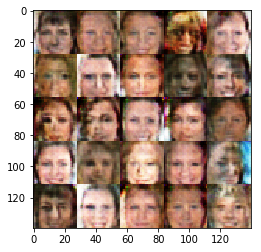

Epoch 1/1... Discriminator Loss:1.3596... Generator Loss:0.7137
Epoch 1/1... Discriminator Loss:1.2924... Generator Loss:1.0426
Epoch 1/1... Discriminator Loss:1.4932... Generator Loss:1.2461
Epoch 1/1... Discriminator Loss:1.2166... Generator Loss:0.8762
Epoch 1/1... Discriminator Loss:1.4841... Generator Loss:0.5029
Epoch 1/1... Discriminator Loss:1.3681... Generator Loss:1.1893
Epoch 1/1... Discriminator Loss:1.3478... Generator Loss:0.8007
Epoch 1/1... Discriminator Loss:1.3575... Generator Loss:0.7983
Epoch 1/1... Discriminator Loss:1.4056... Generator Loss:0.6878
Epoch 1/1... Discriminator Loss:1.3702... Generator Loss:0.6225


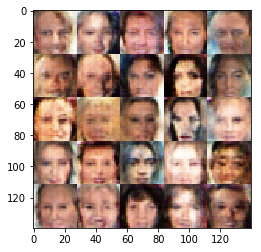

Epoch 1/1... Discriminator Loss:1.5307... Generator Loss:0.6329
Epoch 1/1... Discriminator Loss:1.4833... Generator Loss:0.6875
Epoch 1/1... Discriminator Loss:1.3760... Generator Loss:0.7228
Epoch 1/1... Discriminator Loss:1.2873... Generator Loss:1.0345
Epoch 1/1... Discriminator Loss:1.4340... Generator Loss:0.6251
Epoch 1/1... Discriminator Loss:1.2590... Generator Loss:1.1258
Epoch 1/1... Discriminator Loss:1.2871... Generator Loss:0.8463
Epoch 1/1... Discriminator Loss:1.3743... Generator Loss:0.9270
Epoch 1/1... Discriminator Loss:1.4988... Generator Loss:0.8009
Epoch 1/1... Discriminator Loss:1.3389... Generator Loss:0.8368


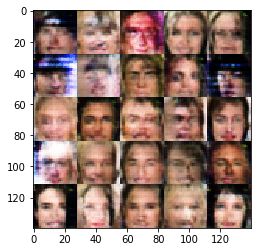

Epoch 1/1... Discriminator Loss:1.3358... Generator Loss:1.0431
Epoch 1/1... Discriminator Loss:1.4062... Generator Loss:0.7389
Epoch 1/1... Discriminator Loss:1.3605... Generator Loss:0.7474
Epoch 1/1... Discriminator Loss:1.5431... Generator Loss:0.4946
Epoch 1/1... Discriminator Loss:1.2171... Generator Loss:0.9367
Epoch 1/1... Discriminator Loss:1.3866... Generator Loss:0.5772
Epoch 1/1... Discriminator Loss:1.4080... Generator Loss:0.6013
Epoch 1/1... Discriminator Loss:1.1691... Generator Loss:0.9683
Epoch 1/1... Discriminator Loss:1.2755... Generator Loss:0.9301
Epoch 1/1... Discriminator Loss:1.3254... Generator Loss:0.7624


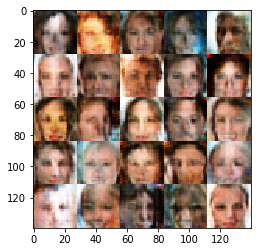

Epoch 1/1... Discriminator Loss:1.2797... Generator Loss:0.8598
Epoch 1/1... Discriminator Loss:1.3362... Generator Loss:0.7867
Epoch 1/1... Discriminator Loss:1.2305... Generator Loss:0.9139
Epoch 1/1... Discriminator Loss:1.4413... Generator Loss:0.6166
Epoch 1/1... Discriminator Loss:1.2867... Generator Loss:0.8047
Epoch 1/1... Discriminator Loss:1.4106... Generator Loss:0.7656
Epoch 1/1... Discriminator Loss:1.3560... Generator Loss:0.7582
Epoch 1/1... Discriminator Loss:1.4256... Generator Loss:0.8230
Epoch 1/1... Discriminator Loss:1.4096... Generator Loss:0.9768
Epoch 1/1... Discriminator Loss:1.3593... Generator Loss:1.0529


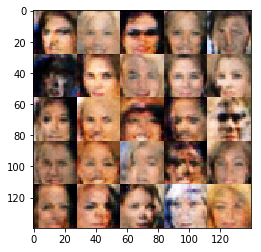

Epoch 1/1... Discriminator Loss:1.2773... Generator Loss:0.8092
Epoch 1/1... Discriminator Loss:1.2888... Generator Loss:0.7745
Epoch 1/1... Discriminator Loss:1.4919... Generator Loss:0.6346
Epoch 1/1... Discriminator Loss:1.5139... Generator Loss:0.4421
Epoch 1/1... Discriminator Loss:1.3900... Generator Loss:0.8297
Epoch 1/1... Discriminator Loss:1.4006... Generator Loss:0.7696
Epoch 1/1... Discriminator Loss:1.4815... Generator Loss:0.6022
Epoch 1/1... Discriminator Loss:1.2627... Generator Loss:0.8097
Epoch 1/1... Discriminator Loss:1.3121... Generator Loss:0.7831
Epoch 1/1... Discriminator Loss:1.2707... Generator Loss:0.9815


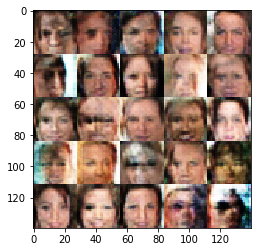

Epoch 1/1... Discriminator Loss:1.3175... Generator Loss:1.1316
Epoch 1/1... Discriminator Loss:1.4088... Generator Loss:0.6507
Epoch 1/1... Discriminator Loss:1.3229... Generator Loss:0.9683
Epoch 1/1... Discriminator Loss:1.2275... Generator Loss:0.9277
Epoch 1/1... Discriminator Loss:1.4049... Generator Loss:1.3398
Epoch 1/1... Discriminator Loss:1.3289... Generator Loss:0.6524
Epoch 1/1... Discriminator Loss:1.3513... Generator Loss:0.7646
Epoch 1/1... Discriminator Loss:1.2531... Generator Loss:0.6843
Epoch 1/1... Discriminator Loss:1.3175... Generator Loss:0.8018
Epoch 1/1... Discriminator Loss:1.1546... Generator Loss:0.8126


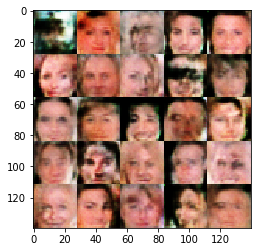

Epoch 1/1... Discriminator Loss:1.3630... Generator Loss:1.2517
Epoch 1/1... Discriminator Loss:1.2356... Generator Loss:1.1765
Epoch 1/1... Discriminator Loss:1.3544... Generator Loss:0.8718
Epoch 1/1... Discriminator Loss:1.3975... Generator Loss:0.6179
Epoch 1/1... Discriminator Loss:1.1635... Generator Loss:0.7806
Epoch 1/1... Discriminator Loss:1.2500... Generator Loss:0.7448
Epoch 1/1... Discriminator Loss:1.4632... Generator Loss:0.5660
Epoch 1/1... Discriminator Loss:1.3211... Generator Loss:0.8086
Epoch 1/1... Discriminator Loss:1.2804... Generator Loss:0.8146
Epoch 1/1... Discriminator Loss:1.3820... Generator Loss:0.7104


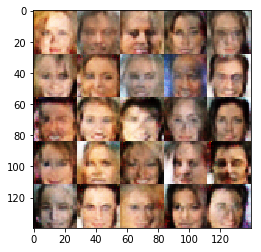

Epoch 1/1... Discriminator Loss:1.2875... Generator Loss:0.7247
Epoch 1/1... Discriminator Loss:1.1919... Generator Loss:0.7946
Epoch 1/1... Discriminator Loss:1.2517... Generator Loss:1.1643
Epoch 1/1... Discriminator Loss:1.6402... Generator Loss:1.3814
Epoch 1/1... Discriminator Loss:1.2507... Generator Loss:0.9212
Epoch 1/1... Discriminator Loss:1.4131... Generator Loss:0.6869
Epoch 1/1... Discriminator Loss:1.5036... Generator Loss:0.4578
Epoch 1/1... Discriminator Loss:1.4399... Generator Loss:1.1494
Epoch 1/1... Discriminator Loss:1.4855... Generator Loss:0.5455
Epoch 1/1... Discriminator Loss:1.3708... Generator Loss:0.6897


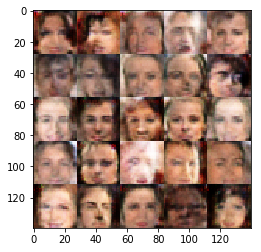

Epoch 1/1... Discriminator Loss:1.3333... Generator Loss:0.7555
Epoch 1/1... Discriminator Loss:1.3342... Generator Loss:0.7454
Epoch 1/1... Discriminator Loss:1.2007... Generator Loss:1.1361
Epoch 1/1... Discriminator Loss:1.3406... Generator Loss:0.9203
Epoch 1/1... Discriminator Loss:1.3317... Generator Loss:1.0122
Epoch 1/1... Discriminator Loss:1.2767... Generator Loss:0.6201
Epoch 1/1... Discriminator Loss:1.2980... Generator Loss:1.1216
Epoch 1/1... Discriminator Loss:1.2602... Generator Loss:0.9232
Epoch 1/1... Discriminator Loss:0.9995... Generator Loss:1.1907
Epoch 1/1... Discriminator Loss:1.2887... Generator Loss:0.6988


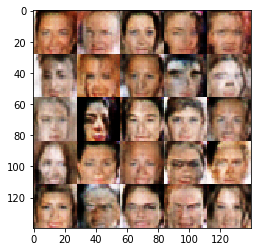

Epoch 1/1... Discriminator Loss:1.3155... Generator Loss:0.8925
Epoch 1/1... Discriminator Loss:1.2981... Generator Loss:0.7707
Epoch 1/1... Discriminator Loss:1.4822... Generator Loss:0.6951
Epoch 1/1... Discriminator Loss:1.3979... Generator Loss:0.7197
Epoch 1/1... Discriminator Loss:1.3242... Generator Loss:0.7447
Epoch 1/1... Discriminator Loss:1.2291... Generator Loss:0.8828
Epoch 1/1... Discriminator Loss:1.3448... Generator Loss:0.7439
Epoch 1/1... Discriminator Loss:1.3504... Generator Loss:0.7451
Epoch 1/1... Discriminator Loss:1.3301... Generator Loss:0.7989
Epoch 1/1... Discriminator Loss:1.2357... Generator Loss:0.8287


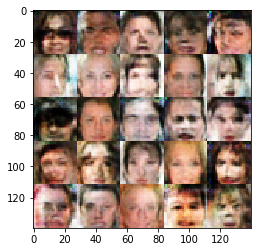

Epoch 1/1... Discriminator Loss:1.3943... Generator Loss:0.5606
Epoch 1/1... Discriminator Loss:1.2628... Generator Loss:0.9036
Epoch 1/1... Discriminator Loss:1.3387... Generator Loss:0.6724
Epoch 1/1... Discriminator Loss:1.3581... Generator Loss:0.7466
Epoch 1/1... Discriminator Loss:1.3610... Generator Loss:1.0735
Epoch 1/1... Discriminator Loss:1.3241... Generator Loss:0.7891


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.